# Proyecto final:



Objetivo: **Supervivencia en cáncer de pulmón.**

## Imports

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split
import re

# Definir las rutas
path_interim = '../data/interim'
path_processed = '../data/processed'
os.makedirs(path_interim, exist_ok=True)
os.makedirs(path_processed, exist_ok=True)


## Comprensión de los Datos

In [17]:
pd.set_option('display.max_columns', None)

In [18]:
df = pd.read_csv('../data/raw/Clinical_data_V2.zip')
df

,Age recode with <1 year olds and 90+,"Race recode (White, Black, Other)",Primary Site - labeled,Histologic Type ICD-O-3,Grade Clinical (2018+),Grade Recode (thru 2017),Combined Summary Stage with Expanded Regional Codes (2004+),Derived EOD 2018 Stage Group Recode (2018+),7th Edition Stage Group Recode (2016-2017),"Derived AJCC Stage Group, 7th ed (2010-2015)",CS tumor size (2004-2015),Tumor Size Summary (2016+),Survival months,Survival months flag,Vital status recode (study cutoff used),SEER cause-specific death classification,Year of diagnosis,Median household income inflation adj to 2023,RX Summ--Surg Prim Site (1998+),Radiation recode,"Chemotherapy recode (yes, no/unk)",Sex,Rural-Urban Continuum Code,Reason no cancer-directed surgery,Total number of in situ/malignant tumors for patient,Total number of benign/borderline tumors for patient,Sequence number,Type of Reporting Source
0,65-69 years,White,"C34.1-Upper lobe, lung",8140,2,Blank(s),Regional by both direct extension and lymph no...,3A,Blank(s),Blank(s),Blank(s),070,0059,Complete dates are available and there are mor...,Alive,Alive or dead of other cause,2018,"$120,000+",33,None/Unknown,Yes,Male,Counties in metropolitan areas ge 1 million pop,Surgery performed,2,0,2nd of 2 or more primaries,Hospital inpatient/outpatient or clinic
1,65-69 years,White,C34.0-Main bronchus,8140,Blank(s),Unknown,Distant site(s)/node(s) involved,Blank(s),IV,Blank(s),Blank(s),109,0027,Complete dates are available and there are mor...,Dead,Dead (attributable to this cancer dx),2016,"$110,000 - $119,999",0,Beam radiation,Yes,Female,Counties in metropolitan areas ge 1 million pop,Not recommended,2,0,2nd of 2 or more primaries,Hospital inpatient/outpatient or clinic
2,65-69 years,Black,"C34.9-Lung, NOS",8041,Blank(s),Unknown,Unknown/unstaged/unspecified/DCO,Blank(s),Blank(s),UNK Stage,999,Blank(s),0000,Complete dates are available and there are mor...,Dead,Dead (attributable to this cancer dx),2014,"$110,000 - $119,999",0,None/Unknown,No/Unknown,Female,Counties in metropolitan areas ge 1 million pop,Not recommended,2,0,2nd of 2 or more primaries,Physicians office/private medical practitioner...
3,80-84 years,White,"C34.1-Upper lobe, lung",8550,Blank(s),Poorly differentiated; Grade III,Regional by direct extension only,Blank(s),Blank(s),IIB,028,Blank(s),0052,Complete dates are available and there are mor...,Dead,Dead (attributable to this cancer dx),2015,"$100,000 - $109,999",33,None/Unknown,No/Unknown,Female,Counties in metropolitan areas ge 1 million pop,Surgery performed,2,0,2nd of 2 or more primaries,Hospital inpatient/outpatient or clinic
4,65-69 years,White,"C34.1-Upper lobe, lung",8140,3,Blank(s),Localized only,1B,Blank(s),Blank(s),Blank(s),033,0012,Complete dates are available and there are mor...,Dead,Alive or dead of other cause,2020,"$120,000+",0,None/Unknown,No/Unknown,Female,Counties in metropolitan areas ge 1 million pop,Not recommended,3,0,2nd of 2 or more primaries,Hospital inpatient/outpatient or clinic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537413,70-74 years,Black,"C34.9-Lung, NOS",8000,9,Blank(s),Unknown/unstaged/unspecified/DCO,99,Blank(s),Blank(s),Blank(s),999,0000,Complete dates are available and there are mor...,Dead,Dead (attributable to this cancer dx),2022,"$70,000 - $74,999",0,None/Unknown,No/Unknown,Male,Counties in metropolitan areas ge 1 million pop,Not recommended,1,0,One primary only,Nursing/convalescent home/hospice
537414,90+ years,White,"C34.9-Lung, NOS",8000,9,Blank(s),Distant site(s)/node(s) involved,4A,Blank(s),Blank(s),Blank(s),999,0016,Complete dates are available and there are mor...,Dead,Dead (attributable to this cancer dx),2021,"$70,000 - $74,999",0,None/Unknown,No/Unknown,Male,"Counties in metropolitan areas of 250,000 to 1...",Not recommended,1,0,One primary only,Hospital inpatient/outpatient or clinic
537415,75-79 years,White,"C34.9-Lung, NOS",8000,9,Blank(s),Unknown/unstage

In [19]:
df.shape

(537418, 28)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537418 entries, 0 to 537417
Data columns (total 28 columns):
 #   Column                                                       Non-Null Count   Dtype 
---  ------                                                       --------------   ----- 
 0   Age recode with <1 year olds and 90+                         537418 non-null  object
 1   Race recode (White, Black, Other)                            537418 non-null  object
 2   Primary Site - labeled                                       537418 non-null  object
 3   Histologic Type ICD-O-3                                      537418 non-null  int64 
 4   Grade Clinical (2018+)                                       537418 non-null  object
 5   Grade Recode (thru 2017)                                     537418 non-null  object
 6   Combined Summary Stage with Expanded Regional Codes (2004+)  537418 non-null  object
 7   Derived EOD 2018 Stage Group Recode (2018+)                  537418 non-nu

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Histologic Type ICD-O-3,537418.0,8122.758679,126.531359,8000.0,8041.0,8072.0,8140.0,9581.0
Year of diagnosis,537418.0,2016.977267,3.142155,2012.0,2014.0,2017.0,2020.0,2022.0
RX Summ--Surg Prim Site (1998+),537418.0,9.517683,20.696553,0.0,0.0,0.0,0.0,99.0
Total number of in situ/malignant tumors for patient,537418.0,1.422438,0.751866,1.0,1.0,1.0,2.0,34.0
Total number of benign/borderline tumors for patient,537418.0,0.011875,0.112040,0.0,0.0,0.0,0.0,4.0


## EDA

### Duplicados y nulos

In [22]:
df.duplicated().sum()

np.int64(4977)

In [23]:
df.drop_duplicates(inplace=True)

In [24]:
df.duplicated().sum()

np.int64(0)

In [25]:
df.shape

(532441, 28)

### Analisis de nuestras variables, para encontrar valores nulos, faltantes y duplicados

Definimos los términos que SEER suele usar para datos faltantes:

In [26]:
terminos_nulos = ['Unknown', 'Unknown/no information', 'Blank', 'N/A', 'Not applicable']

In [27]:
resumen_nulos = []
for col in df.columns:
    # 1. Contar NaN técnicos
    nulos_reales = df[col].isnull().sum()

    # 2. Contar "Unknown" (solo en columnas tipo objeto o convirtiendo a string)
    # Buscamos también códigos numéricos comunes en SEER como 999 o 888 si es necesario
    nulos_disfrazados = df[df[col].astype(str).str.contains('|'.join(terminos_nulos), case=False, na=False)].shape[0]

    total = nulos_reales + nulos_disfrazados
    porcentaje = (total / len(df)) * 100

    resumen_nulos.append({
        'Columna': col,
        'NaN': nulos_reales,
        'Unknown/Disfrazados': nulos_disfrazados,
        'Total Faltantes': total,
        '% Faltante': round(porcentaje, 2)})

In [28]:
df_calidad = pd.DataFrame(resumen_nulos).sort_values(by='% Faltante', ascending=False)

In [29]:
df_calidad[df_calidad['Total Faltantes'] > 0]

,Columna,NaN,Unknown/Disfrazados,Total Faltantes,% Faltante
8,7th Edition Stage Group Recode (2016-2017),1126,433555,434681,81.64
5,Grade Recode (thru 2017),0,402460,402460,75.59
9,"Derived AJCC Stage Group, 7th ed (2010-2015)",431,338662,339093,63.69
10,CS tumor size (2004-2015),0,338662,338662,63.61
20,"Chemotherapy recode (yes, no/unk)",0,326817,326817,61.38
19,Radiation recode,0,325591,325591,61.15
4,Grade Clinical (2018+),0,292665,292665,54.97
7,Derived EOD 2018 Stage Group Recode (2018+),0,292665,292665,54.97
11,Tumor Size Summary (2016+),0,193779,193779,36.39
1,"Race recode (White, Black, Other)",0,45213,45213,8.49


#### Observaciones:

**Datos excluyentes:**
> Las columnas con más del 60% de faltantes (AJCC 7th ed) y las que tienen un 54% (2018+) suman casi el 100%.
>
> Explicación: Esto confirma que nuestro dataset abarca muchos años. Los pacientes que tienen datos en la "7th ed" (2010-2015) no los tienen en la de "2018+", y viceversa.
>
> No podemos borrar estas filas. Si borramos los "Unknown" de la 7ma edición, estaríamos borrando a todos los pacientes diagnosticados después de 2018.
>

**Columnas Críticas (Análisis de Riesgo)**
Hay tres variables donde los faltantes son especialmente relevantes:
> 1. Race recode (8.46%): Es un porcentaje alto para una variable demográfica básica.
>
> 2. Survival months (2.43%): Son 13,051 pacientes sin tiempo de supervivencia.
>
> 3. Diagnostic Confirmation (3.78%): Es importante saber si el cáncer se confirmó por biopsia o solo por observación clínica.
>

**Datos casi Perfectos:**
Las columnas al final de la tabla están impecables:
>
> Rural-Urban, Income, PRCDA: Tienen menos del 0.2% de faltantes.
>

**Toma de decision:**

Limpieza de Supervivencia: Eliminaremos los registros donde no sabemos cuánto tiempo vivió el paciente.

Limpieza Geográfica: Eliminaremos los pocos nulos de ingresos y zona rural/urbana.

Preservación Clínica: No eliminaremos los "Unknown" de las etapas (T, N, M, Grade), sino los trataremos como una categoría estadística legítima.

Confirmación de diagnóstico (3.78%): Los trataremos más adelante cuando analicemos la variable más a fondo.
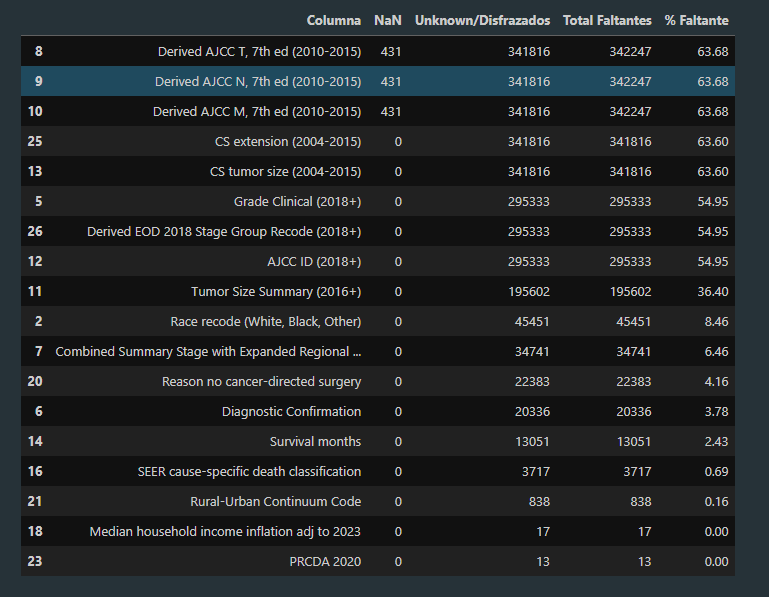

In [30]:
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.columns.tolist()

['Age_recode_with_<1_year_olds_and_90+',
 'Race_recode_White,_Black,_Other',
 'Primary_Site_-_labeled',
 'Histologic_Type_ICD-O-3',
 'Grade_Clinical_2018+',
 'Grade_Recode_thru_2017',
 'Combined_Summary_Stage_with_Expanded_Regional_Codes_2004+',
 'Derived_EOD_2018_Stage_Group_Recode_2018+',
 '7th_Edition_Stage_Group_Recode_2016-2017',
 'Derived_AJCC_Stage_Group,_7th_ed_2010-2015',
 'CS_tumor_size_2004-2015',
 'Tumor_Size_Summary_2016+',
 'Survival_months',
 'Survival_months_flag',
 'Vital_status_recode_study_cutoff_used',
 'SEER_cause-specific_death_classification',
 'Year_of_diagnosis',
 'Median_household_income_inflation_adj_to_2023',
 'RX_Summ--Surg_Prim_Site_1998+',
 'Radiation_recode',
 'Chemotherapy_recode_yes,_no/unk',
 'Sex',
 'Rural-Urban_Continuum_Code',
 'Reason_no_cancer-directed_surgery',
 'Total_number_of_in_situ/malignant_tumors_for_patient',
 'Total_number_of_benign/borderline_tumors_for_patient',
 'Sequence_number',
 'Type_of_Reporting_Source']

## Análisis Univariante

**Nota** Cambiamos el nombre de uno de nuestros datos dentro de la variable 'Race_recode_White,_Black,_Other',  por 'Others'

In [31]:
df['Race_recode_White,_Black,_Other'] = df['Race_recode_White,_Black,_Other'].replace(
    'Other (American Indian/AK Native, Asian/Pacific Islander)', 'Others')

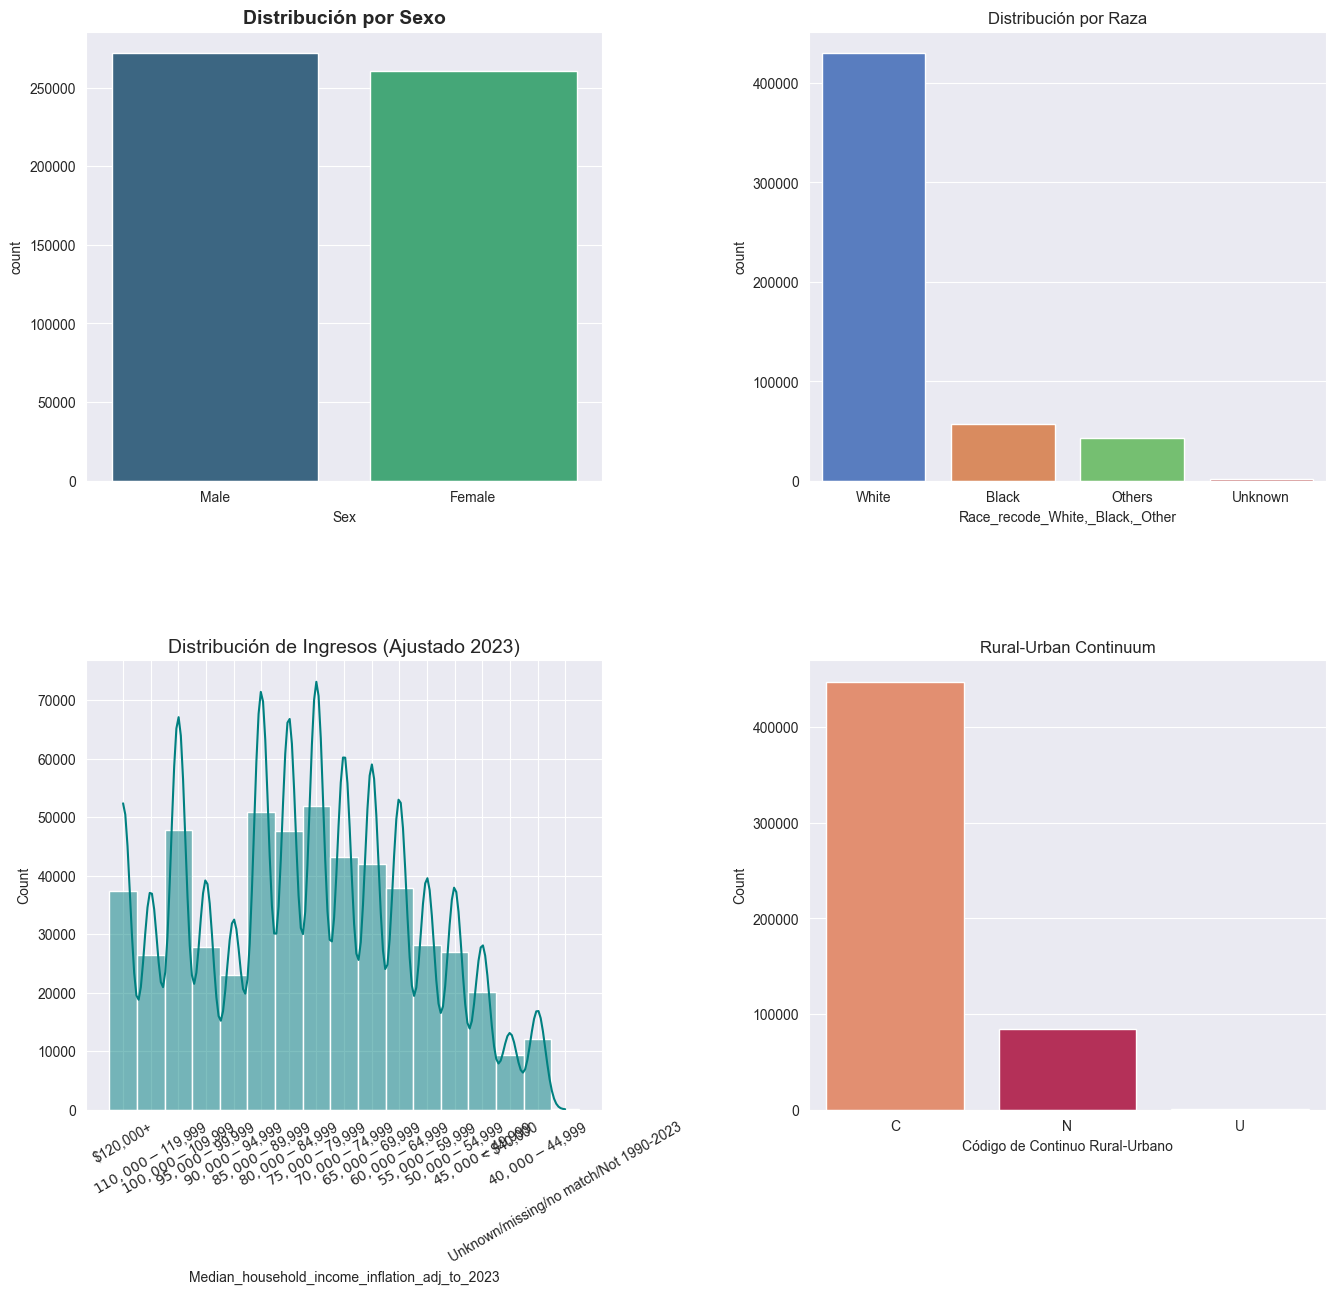

In [32]:
# 1. Limpieza de la variable Rural-Urban para que solo quede el código numérico (1-9)
# Esto evita que las descripciones largas rompan el eje X
df['Rural_Code_Clean'] = df['Rural-Urban_Continuum_Code'].astype(str).str.extract('(\d+)').astype(float)

# Configuración de la figura
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
plt.subplots_adjust(hspace=0.4, wspace=0.4) # Espacio extra entre gráficos

# --- 1. SEXO ---
sns.countplot(data=df, x='Sex', ax=axes[0,0], palette='viridis', hue='Sex', legend=False)
axes[0,0].set_title('Distribución por Sexo', fontsize=14, fontweight='bold')

# --- 2. RAZA (Horizontal para lectura perfecta) ---
sns.countplot(data=df, x='Race_recode_White,_Black,_Other', ax=axes[0,1], palette='muted', hue='Race_recode_White,_Black,_Other', legend=False)
axes[0,1].set_title('Distribución por Raza')

# 3. Ingresos (Histograma más limpio)
sns.histplot(df['Median_household_income_inflation_adj_to_2023'], kde=True, ax=axes[1,0], color='teal')
axes[1,0].set_title('Distribución de Ingresos (Ajustado 2023)', fontsize=14)
axes[1,0].tick_params(axis='x', rotation=30) # Rotamos un poco los números

# --- 4. RURAL-URBANO (Corregido y Ordenado) ---

df['Rural_Code_Temp'] = df['Rural-Urban_Continuum_Code'].astype(str).str.strip()
# 2. Extraemos el primer carácter (que suele ser el código 1-9)
df['Rural_Code_Clean'] = df['Rural_Code_Temp'].str[0]
# Ordenamos del 1 (Urbano) al 9 (Rural)
sns.countplot(data=df, x='Rural_Code_Clean', ax=axes[1,1], palette='rocket_r', hue='Rural_Code_Clean', legend=False)
axes[1,1].set_title('Rural-Urban Continuum')
axes[1,1].set_xlabel('Código de Continuo Rural-Urbano')
axes[1,1].set_ylabel('Count')
plt.show()

#### Oberservaciones

1. **Distribución por Sexo:** Está muy bien balanceada (casi 50/50). Esto es excelente para el modelo porque no habrá un sesgo de género importante.

2. **Distribución por Raza:** Hay un desbalance extremo. La gran mayoría de los pacientes son "White". Para el Machine Learning, esto es una alerta: el modelo será muy bueno prediciendo para este grupo, pero podría fallar en minorías. Consideraremos técnicas de balanceo más adelante.

3. **Distribución de Ingresos:** El gráfico muestra picos y valles. Esto sugiere que los datos de ingresos vienen en "escalones" (rangos prefijados). La línea de tendencia (KDE) sube al final, indicando una concentración en niveles de ingresos altos.

4. **Rural-Urban:** La mayoría vive en zonas metropolitanas. Los casos rurales son pocos.

- Significado de los Códigos Detectados
    - **C** (Counties): Representa registros asociados a condados específicos. Es probable que el resto de la descripción fuera "Counties in metro areas..." o similar.

    - **N** (Non-metro / Not): Generalmente indica áreas no metropolitanas o categorías que comienzan con "Non-metropolitan".

    - **U** (Unknown): Registros donde la ubicación rural-urbana es desconocida o no fue reportada.

## Análisis Bivariante (Relación con el Target)

- **Survival vs Stage:** ¿Cuánto baja la media de meses de vida conforme sube el Stage?

- **Survival vs Sex:** ¿Existen diferencias de supervivencia entre géneros?

### Crearemos una variante nueva que contendra 4 variantes

Crearemos una variante nueva, apartir de estas 4 variables que ya tenemos:

- 'Combined_Summary_Stage_with_Expanded_Regional_Codes_2004+'
- 'Derived_EOD_2018_Stage_Group_Recode_2018+',
- '7th_Edition_Stage_Group_Recode_2016-2017',
- 'Derived_AJCC_Stage_Group,_7th_ed_2010-2015'

In [33]:
def encontrar_columna(lista_cols, palabra_clave):
    for c in lista_cols:
        if palabra_clave in c:
            return c
    return None

cols_actuales = df.columns.tolist()

c1 = encontrar_columna(cols_actuales, 'Combined_Summary_Stage')
c2 = encontrar_columna(cols_actuales, 'Derived_EOD_2018')
c3 = encontrar_columna(cols_actuales, '7th_Edition_Stage_Group')
c4 = encontrar_columna(cols_actuales, 'Derived_AJCC_Stage_Group')

stage_cols = [c for c in [c1, c2, c3, c4] if c is not None]

In [34]:
def simplificar_etapa(val):
    val = str(val).upper()
    if any(x in val for x in ['IV', 'DISTANT']): return 'Stage IV'
    if 'III' in val: return 'Stage III'
    if 'II' in val: return 'Stage II'
    if any(x in val for x in ['I', 'LOCALIZED']): return 'Stage I'
    if any(x in val for x in ['0', 'IN SITU']): return 'Stage 0'
    return 'Unknown'

In [35]:
df['Stage_Final'] = df[stage_cols].fillna('').agg(' '.join, axis=1).apply(simplificar_etapa)

In [36]:
col_raza = [c for c in cols_actuales if 'Race_recode' in c][0]
df[col_raza] = df[col_raza].replace(to_replace=r'.*Other.*', value='Others', regex=True)

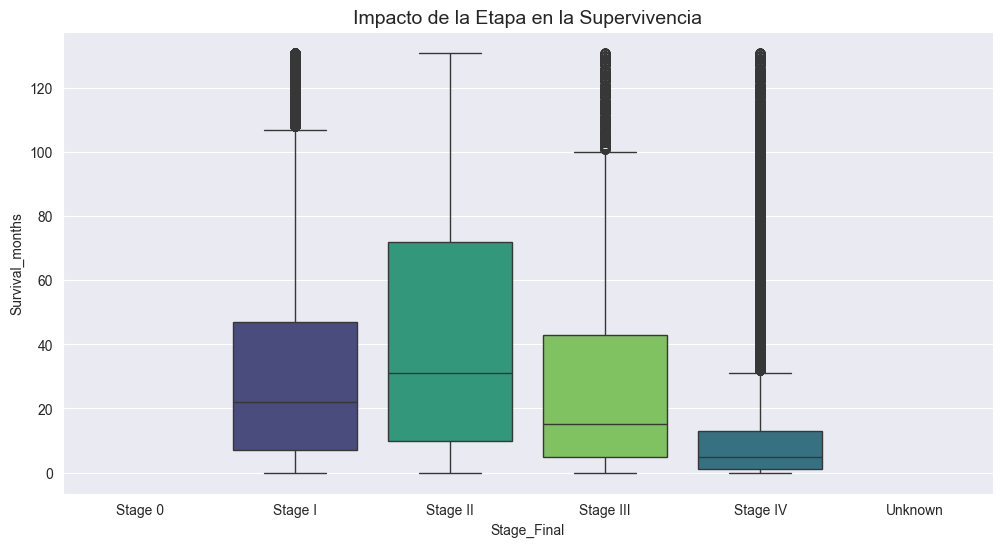

In [37]:
plt.figure(figsize=(12, 6))
df['Survival_months'] = pd.to_numeric(df['Survival_months'], errors='coerce')
orden = ['Stage 0', 'Stage I', 'Stage II', 'Stage III', 'Stage IV', 'Unknown']

sns.boxplot(data=df, x='Stage_Final', y='Survival_months', order=orden, palette='viridis', hue='Stage_Final', legend=False)
plt.title('Impacto de la Etapa en la Supervivencia', fontsize=14)
plt.show()

#### Observaciones

- **Tendencia Esperada:** Existe una clara disminución de la mediana de supervivencia conforme avanza la etapa. La "caja" del Stage IV es notablemente más baja que la del Stage II, lo que valida que Stage_Final es un predictor crítico.

- **Stage II vs Stage I:** Curiosamente, en el gráfico la mediana del Stage II parece ligeramente superior a la del Stage I. Esto podría deberse a que el Stage I tiene una dispersión muy alta de valores bajos, o quizás a la forma en que SEER agrupa ciertos diagnósticos tempranos.

- **Outliers (Puntos grises):** Hay una gran cantidad de puntos por encima de los "bigotes" en todas las etapas. Estos son pacientes con una supervivencia excepcionalmente larga para su diagnóstico.

- **Stage 0 y Unknown:** Aparecen vacíos. Esto confirma que debemos revisar si en la (Ingeniería de caracteristicas) debemos imputar estos valores o si simplemente hay muy pocos registros para graficar una "caja".

## Matriz de Correlación y Outliers

### Identificación Numérica de Outliers


Para no solo ver los puntos en el gráfico, sino saber cuántos registros "atípicos" tenemos en Survival_months:

In [38]:
Q1 = df['Survival_months'].quantile(0.25)
Q3 = df['Survival_months'].quantile(0.75)
IQR = Q3 - Q1

limite_superior = Q3 + 1.5 * IQR
cant_outliers = len(df[df['Survival_months'] > limite_superior])

In [39]:
f"Límite para considerar un valor como atípico: {limite_superior:.2f} meses", f"Cantidad de pacientes con supervivencia excepcionalmente alta: {cant_outliers}"

('Límite para considerar un valor como atípico: 72.00 meses',
 'Cantidad de pacientes con supervivencia excepcionalmente alta: 39547')

### Matriz de Correlación

**NOTA** Hacemos una limpieza de la Variable de Ingresos

In [40]:
def limpiar_ingreso_rango(valor):
    valor = str(valor).replace('$', '').replace(',', '')

    # Caso para rangos: "110000 - 119999"
    if '-' in valor:
        partes = re.findall(r'\d+', valor)
        if len(partes) == 2:
            return (float(partes[0]) + float(partes[1])) / 2

    # Caso para valores con "+" : "120000+"
    numeros = re.findall(r'\d+', valor)
    if numeros:
        return float(numeros[0])

    return np.nan

df['Income_Numeric'] = df['Median_household_income_inflation_adj_to_2023'].apply(limpiar_ingreso_rango)

**NOTA** Limpiamos la variable edad

In [41]:
def limpiar_edad(valor):
    valor = str(valor).lower()
    # Extraer todos los números
    numeros = re.findall(r'\d+', valor)

    if len(numeros) == 2: # Rango "60-64"
        return (float(numeros[0]) + float(numeros[1])) / 2
    elif len(numeros) == 1: # Casos como "90+" o "<1"
        return float(numeros[0])
    return np.nan

# Creamos la columna numérica de Edad
col_edad_original = 'Age_recode_with_<1_year_olds_and_90+' # Asegúrate que este sea el nombre exacto
df['Age_Numeric'] = df[col_edad_original].apply(limpiar_edad)

**NOTA** Limpiamos y buscamos la variable que tenga relacion con tamaños del tumor

In [42]:
# Buscamos las columnas de tamaño (usando nombres flexibles por si hay variaciones)
col_tumor_antigua = [c for c in df.columns if 'CS_tumor_size_2004' in c][0]
col_tumor_nueva = [c for c in df.columns if 'Tumor_Size_Summary_2016' in c][0]

def limpiar_tumor(row):
    # Intentamos obtener el valor de la columna más reciente primero
    val = row[col_tumor_nueva] if pd.notnull(row[col_tumor_nueva]) else row[col_tumor_antigua]

    try:
        val = float(val)
        # En SEER, 990-998 son códigos especiales y 999 es desconocido
        if val >= 990:
            return np.nan
        return val
    except:
        return np.nan

df['Tumor_Size_Clean'] = df.apply(limpiar_tumor, axis=1)

In [43]:
mapa_stage = {
    'Stage 0': 0,
    'Stage I': 1,
    'Stage II': 2,
    'Stage III': 3,
    'Stage IV': 4,
    'Unknown': np.nan}

df['Stage_Rank'] = df['Stage_Final'].map(mapa_stage)

# 2. LIMPIEZA DE GRADO (Si no se hizo antes)
cols_g = [c for c in df.columns if 'grade' in c.lower() and 'recode' in c.lower()]
if cols_g:
    def mapear_grado(val):
        val = str(val).lower()
        if 'well differentiated' in val: return 1
        if 'moderately' in val: return 2
        if 'poorly' in val: return 3
        if 'undifferentiated' in val or 'anaplastic' in val: return 4
        return np.nan
    df['Grade_Numeric'] = df[cols_g[0]].apply(mapear_grado)

In [44]:
df['Survival_months'] = pd.to_numeric(df['Survival_months'], errors='coerce')

### Visualizamos la matriz de correlacion

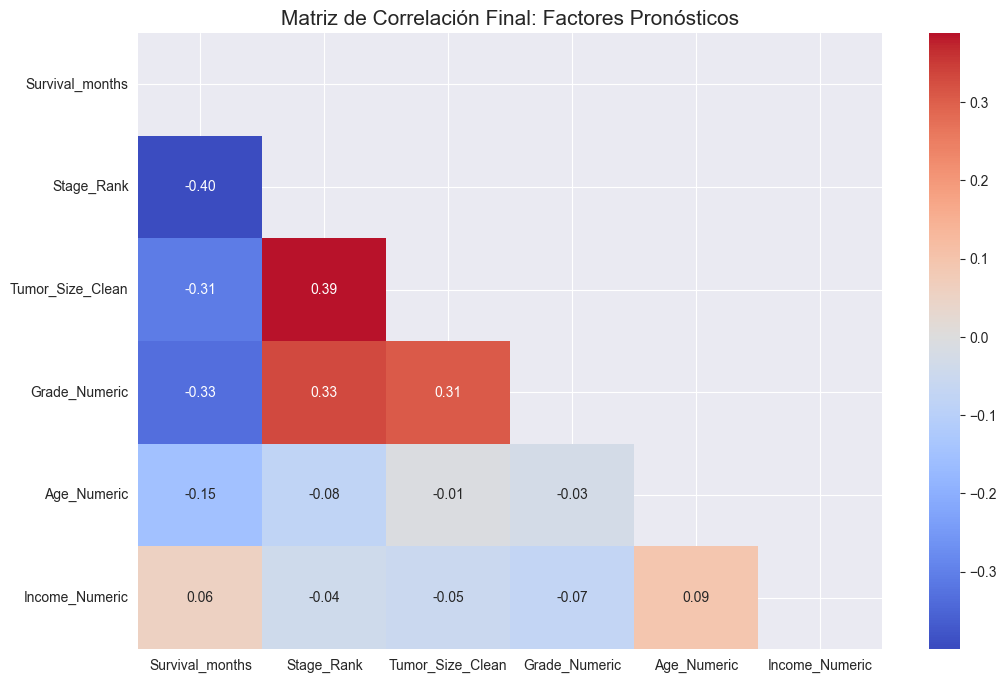

In [45]:
columnas_finales = [
    'Survival_months',
    'Stage_Rank',
    'Tumor_Size_Clean',
    'Grade_Numeric',
    'Age_Numeric',
    'Income_Numeric']

# Calculamos correlación (Spearman es ideal para etapas y grados)
matriz = df[columnas_finales].corr(method='spearman')

# Máscara para ocultar la mitad superior (más limpio visualmente)
mask = np.triu(np.ones_like(matriz, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(matriz, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('Matriz de Correlación Final: Factores Pronósticos', fontsize=15)
plt.show()

#### Observaciones

- **El factor dominante:** La Etapa (Stage_Rank) tiene la correlación negativa más fuerte (-0.40) con la supervivencia. Esto confirma visualmente lo que veíamos en tu primer Boxplot: a mayor etapa, menos tiempo de vida.

- **La tríada biológica:** El Tamaño del Tumor (-0.31) y el Grado Histológico (-0.33) tienen casi el mismo peso que la etapa. Esto valida nuestra decisión de rescatar estas variables; sin ellas, el modelo perdería el 60% de su capacidad explicativa.

- **Ingresos y Edad:** Curiosamente, el ingreso tiene una correlación muy baja (0.06). Esto sugiere que, en este dataset, la biología del cáncer es mucho más determinante que el nivel socioeconómico.

In [46]:
# 1. Eliminamos filas donde no hay Target (Supervivencia)
df_final = df.dropna(subset=['Survival_months']).copy()

# 2. Imputamos nulos en variables clínicas con la mediana
# Esto rellena los huecos que vimos en el mapa de calor
cols_a_imputar = ['Tumor_Size_Clean', 'Grade_Numeric', 'Stage_Rank', 'Age_Numeric', 'Income_Numeric']
for col in cols_a_imputar:
    df_final[col] = df_final[col].fillna(df_final[col].median())

# 3. Verificación final de nulos
print("Nulos restantes tras limpieza e imputación:")

df_final[cols_a_imputar + ['Survival_months']].isnull().sum() , df_final.shape

Nulos restantes tras limpieza e imputación:


(Tumor_Size_Clean    0
 Grade_Numeric       0
 Stage_Rank          0
 Age_Numeric         0
 Income_Numeric      0
 Survival_months     0
 dtype: int64,
 (523735, 36))

## Ingeniería de características

In [47]:
# 1. Filtro de calidad (Reporting Source)
if 'Type_of_Reporting_Source' in df.columns:
    inicial = len(df)
    df = df[~df['Type_of_Reporting_Source'].isin(['Death certificate only', 'Autopsy only'])]
    print(f"Registros eliminados (Autopsias/Certificados): {inicial - len(df)}")

# 2. Limpieza estricta del Target
df = df.dropna(subset=['Survival_months'])

# 3. Mapeo ORDINAL para la Etapa (Crucial para el modelo)
# Esto asegura que Stage IV > Stage I numéricamente
mapa_stage = {
    'Stage 0': 0, 'Stage I': 1, 'Stage II': 2,
    'Stage III': 3, 'Stage IV': 4, 'Unknown': np.nan}
df['Stage_Rank'] = df['Stage_Final'].map(mapa_stage)

# 4. Variables Categóricas Nominales (Sin orden: Sexo y Raza)
# Usaremos pd.get_dummies más adelante o LabelEncoder aquí mismo pero con cuidado
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Sex_Encoded'] = le.fit_transform(df['Sex'].astype(str))
df['Race_Encoded'] = le.fit_transform(df['Race_recode_White,_Black,_Other'].astype(str))

# 5. Creación de la variable de interacción (Opcional pero recomendada)
# Combina agresividad celular con tamaño
if 'Tumor_Size_Clean' in df.columns and 'Grade_Numeric' in df.columns:
    df['Tumor_Aggressiveness'] = df['Tumor_Size_Clean'] * df['Grade_Numeric']

f"Ingeniería final completada con jerarquía de etapas."

Registros eliminados (Autopsias/Certificados): 8706


'Ingeniería final completada con jerarquía de etapas.'

In [48]:
df['Tumor_Aggressiveness'] = df['Tumor_Size_Clean'] * df['Grade_Numeric']

In [51]:
# 1. Convertir a numérico y manejar nulos
df['Total_Tumors_Count'] = pd.to_numeric(df['Total_number_of_in_situ/malignant_tumors_for_patient'], errors='coerce').fillna(1)

# 2. Creamos una variable de "Multicentricidad"
# Esto ayuda al modelo a distinguir rápidamente entre un caso primario único y un paciente recurrente
df['Is_Multicentric'] = (df['Total_Tumors_Count'] > 1).astype(int)

### Índice de Tratamiento Agresivo

In [ ]:
# 1. Crear Chemo_Binary (para evitar el KeyError)
df['Chemo_Binary'] = df['Chemotherapy recode (yes, no/unk)'].apply(lambda x: 1 if 'yes' in str(x).lower() else 0)

# 2. Crear Has_Surgery
# RX Summ--Surg Prim Site: 00 es 'No surgery', valores > 00 son tipos de cirugía
df['Has_Surgery'] = df['RX Summ--Surg Prim Site (1998+)'].apply(lambda x: 1 if x > 0 else 0)

# 3. Crear Radiation_Binary
df['Radiation_Binary'] = df['Radiation recode'].apply(lambda x: 0 if 'none' in str(x).lower() or 'unknown' in str(x).lower() else 1)

# 4. Interacción: Triple_Treatment (La variable "Superviviente")
# Esta variable captura si el paciente recibió el protocolo completo
df['Triple_Treatment'] = (
    (df['Chemo_Binary'] == 1) &
    (df['Has_Surgery'] == 1) &
    (df['Radiation_Binary'] == 1)).astype(int)

### Relación Tamaño/Edad:

In [55]:
# Creamos la proporción Tamaño/Edad
# Sumamos 1 a la edad para evitar divisiones por cero en casos raros (<1 año)
df['Tumor_Age_Ratio'] = df['Tumor_Size_Clean'] / (df['Age_Numeric'] + 1)

### Variable Temporal

In [56]:
# Aseguramos que el año sea numérico para que el modelo entienda la progresión
df['Year_of_diagnosis'] = pd.to_numeric(df['Year_of_diagnosis'], errors='coerce')

#### Observaciones

volvemos a limpiar el codigo, incluyendo nuestras nuevas vairables

In [57]:
# 1. Eliminamos filas sin Target
df_final = df.dropna(subset=['Survival_months']).copy()

# 2. Lista actualizada con todas tus nuevas variables de ingeniería
cols_a_imputar = [
    'Tumor_Size_Clean', 'Grade_Numeric', 'Stage_Rank', 'Age_Numeric',
    'Income_Numeric', 'Total_Tumors_Count', 'Tumor_Age_Ratio', 'Year_of_diagnosis']

# Imputación inteligente
for col in cols_a_imputar:
    if col in df_final.columns:
        df_final[col] = df_final[col].fillna(df_final[col].median())

# 3. Verificación de seguridad
print(f"Dimensiones finales del dataset: {df_final.shape}")
print(df_final[cols_a_imputar + ['Survival_months']].isnull().sum())

Dimensiones finales del dataset: (523735, 42)
Tumor_Size_Clean      0
Grade_Numeric         0
Stage_Rank            0
Age_Numeric           0
Income_Numeric        0
Total_Tumors_Count    0
Tumor_Age_Ratio       0
Year_of_diagnosis     0
Survival_months       0
dtype: int64


## Guardamos nuestros DataFrame

In [ ]:
for folder in ['data/interim', 'data/processed']:
    os.makedirs(folder, exist_ok=True)
df.to_csv('data/interim/seer_final_eng.csv', index=False)

In [60]:
ruta_carpeta = r"C:\Users\elius\Desktop\Python-Data Scients\sp-ml-20-final-project-g1\data\processed"
nombre_archivo = "dataset_procesado_final.csv"
ruta_final = os.path.join(ruta_carpeta, nombre_archivo)

features_para_ml = [
    'Survival_months',      # Nuestra variable objetivo (Target)
    'Stage_Rank',           # Clínica limpia
    'Age_Numeric',          # Clínica limpia
    'Tumor_Size_Clean',     # Clínica limpia
    'Grade_Numeric',        # Clínica limpia
    'Sex_Encoded',          # Categórica codificada
    'Race_Encoded',         # Categórica codificada
    'Income_Numeric',       # Socioeconómica
    'Year_of_diagnosis',    # Temporal
    'Total_Tumors_Count',   # Carga tumoral
    'Is_Multicentric',      # Carga tumoral
    'Tumor_Age_Ratio',      # Ingeniería avanzada
    'Primary_Site_-_labeled']

df_final = df_final[features_para_ml].copy()

df_final.to_csv(ruta_final, index=False)